## Setting up: 

In [8]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import datetime
# importing the module
import json
import os

%load_ext autoreload
%autoreload 2

#additional functions:
from datetime import date
from helper_functions.helper_functions import *
from helper_functions.ml_methods_labs import *
from helper_functions.losses import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data: 

- train.csv - Training set of 250000 events. The file starts with the ID column, then the label column (the y you have to predict), and finally 30 feature columns.
- test.csv - The test set of around 568238 events - Everything as above, except the label is missing.
- sample-submission.csv - a sample submission file in the correct format. The sample submission always predicts -1, that is ‘background’.

**Note:**
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [2]:
DATA_TRAIN_PATH = 'data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print(f'training data shape: y {y.shape}, X {tX.shape}')

training data shape: y (250000,), X (250000, 30)


In [3]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print(f'test data shape: X {tX_test.shape}')

test data shape: X (568238, 30)


In [4]:
### Encoding of y: 
y_enc = (y+1)/2
y = y_enc
y.shape

(250000,)

In [9]:
tX_std, tX_test_std, y = pre_processing(tX_test, tX, y, 2)

Plot histogram of raw data:

In [ ]:
    data_ind = [
    'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h',
    'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet',
    'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
    'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt',
    'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi',
    'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num',
    'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
    'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi', 'PRI_jet_all_pt'
]

In [ ]:
def plot_hist(tX, medians=None, with_med = False):
    data_ind = [
    'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h',
    'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet',
    'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
    'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt',
    'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi',
    'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num',
    'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
    'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi', 'PRI_jet_all_pt'
]
    fig, axs = plt.subplots(5, 6, figsize=(20, 20))
    m = 0
    for i in range(6):
        for j in range(5):
            bins = np.linspace(np.min(tX[:, m]), np.max(tX[:, m]), 50)
            axs[j, i].hist(tX[:, m], bins = bins)
            if with_med:
                axs[j, i].axvline(medians[m], color='r', label = 'median')
            axs[j, i].set_title(data_ind[m])
            m += 1
    plt.suptitle('Histograms of raw data:', fontsize=14)
    fig.show()

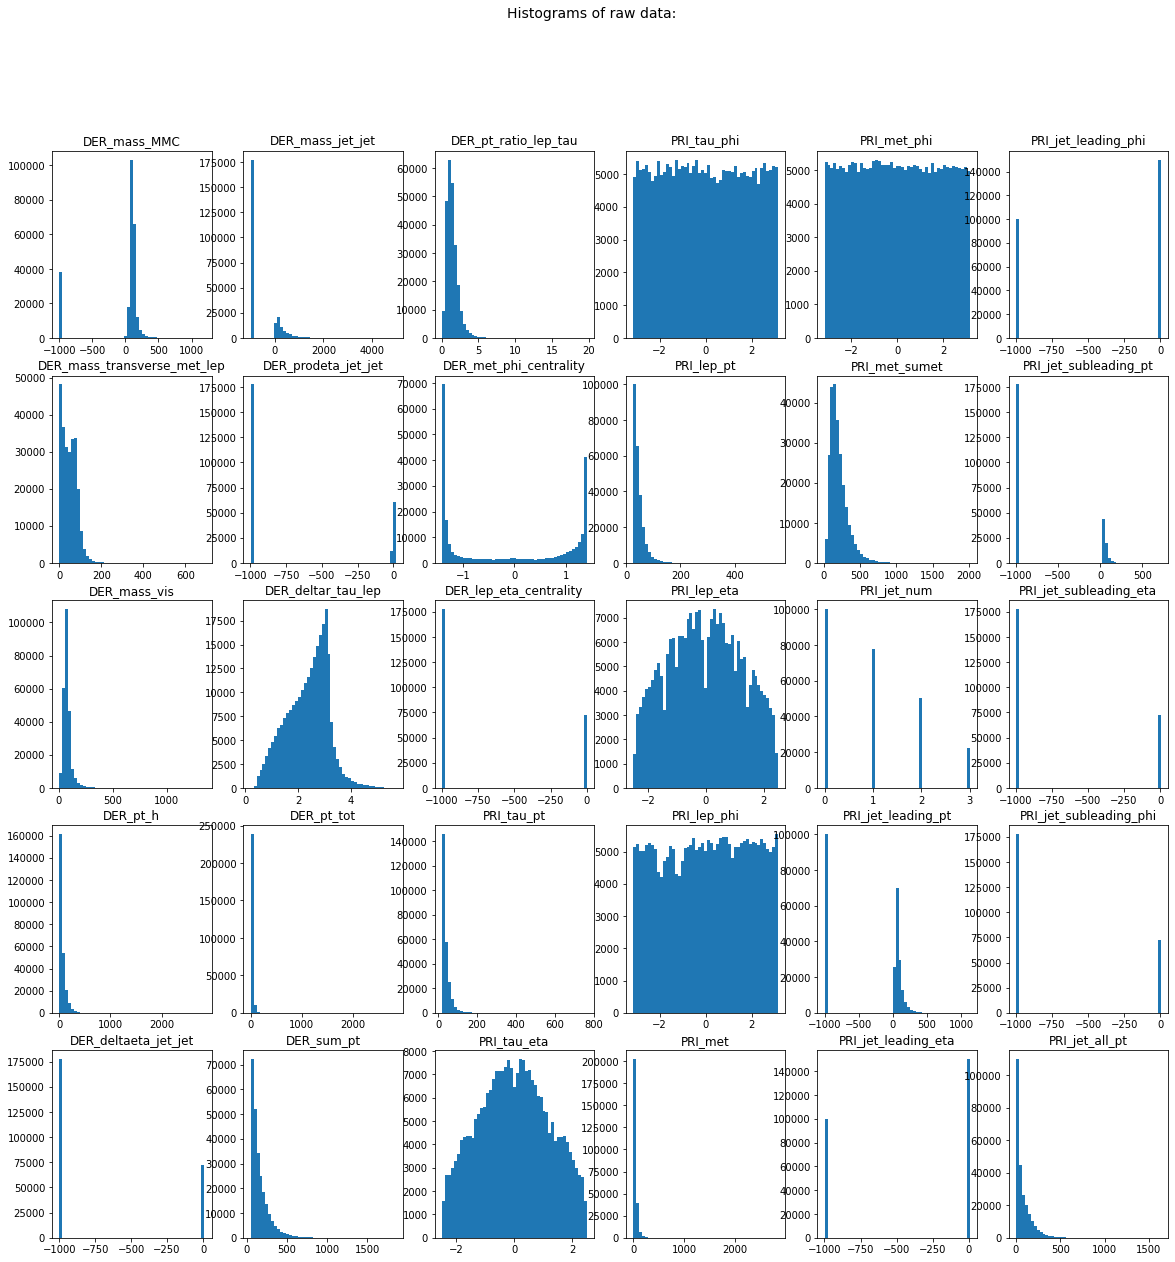

In [223]:
plot_hist(tX)

### Pre-processing:

#### Invalid values:
Histogram after replacing -999 values:

In [ ]:
invalid_identifier = -999
tX_invalid, medians = replace_invalid_values(tX,
                                              invalid_identifier,
                                              mean=False)

#### Outliers: 

In [ ]:
delta = 1.5
tX_filtered, medians = replace_outlayers_values(tX_invalid, delta, mean = False)

#### Choose data: 

In [ ]:
tX = tX_filtered    

In [ ]:
# polynonmial expansion:
POLY = 2
tX_pol = poly_feats(tX, POLY)

# standardize:
tX_std = standardize(tX_pol)

In [ ]:
tX_std.shape

## Implement ML methods:

You should take care of the following:
- Return type: Note that all functions should return: (w, loss), which is the last weight vector of the method, and the corresponding loss value (cost function). Note that while in previous labs you might have kept track of all encountered w for iterative methods, here we only want the last one.
- File names: Please provide all function implementations in a single python file, called implementations.py.
- All code should be easily readable and commented.
- Note that we might automatically call your provided methods and evaluate for correct implementation

### Cross validation:
Create cross validation method in order to evaluate the loss better. 

Different models that will be trainable:

In [10]:
models = {
    'LS_GD': 'Least squares with GD',
    'LS_SGD': 'Least squares with SGD',
    'LS_normal': 'Least squares with normal equations',
    'RR_normal': 'Ridge regression with normal equations',
    'LR': 'Logistic regression with GD'
}

Default json parameters for training, for special parameters take other file or create your own dictionary: 

In [16]:
with open('data/parameters.json') as json_file:
    parameters = json.load(json_file)

### Least Squares GD:

Least squares with GD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],
Parameters:{'lambda_': 0.0, 'lr': 0.01, 'max_iters': 100, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Overall data shape:(215311, 61)
Training data shape:(172248,61)
Validation data shape:(43062,61)
K = 1
Final loss:0.1827
Final accuracy:47.4293%
------------------
K = 2
Final loss:0.1790
Final accuracy:47.1831%
------------------
K = 3
Final loss:0.1774
Final accuracy:46.4214%
------------------
K = 4
Final loss:0.1775
Final accuracy:46.7233%
------------------
K = 5
Final loss:0.1770
Final accuracy:46.7721%
------------------
Average loss: 0.18
Average accuracy: 46.91%
Best loss:0.17704040160648665
Best accuracy:46.77209604755933
------------------
Loss evolution: (saved in data/results/plots/)


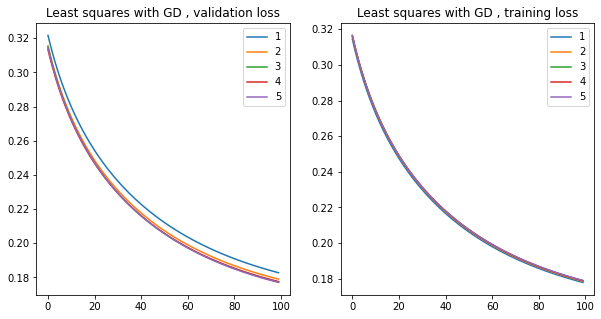

In [21]:
## Least squares GD: 
best_w, avg_loss = least_squares_GD(y=y,
                                 tX=tX_std,
                                 initial_w=np.zeros(tX_std.shape[1]),
                                 max_iters=100,
                                 gamma=0.01)

### Least Squares SGD:


Least squares with SGD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],
Parameters:{'lambda_': 0.0, 'lr': 0.01, 'max_iters': 100, 'K': 5, 'batch_size': 1, 'poly': 2}
------------------
START TRAINING:
Overall data shape:(215311, 61)
Training data shape:(172248,61)
Validation data shape:(43062,61)
K = 1
Final loss:0.3155
Final accuracy:44.2594%
------------------
K = 2
Final loss:0.2754
Final accuracy:47.1529%
------------------
K = 3
Final loss:0.2831
Final accuracy:47.2226%
------------------
K = 4
Final loss:0.6273
Final accuracy:59.6187%
------------------
K = 5
Final loss:0.2356
Final accuracy:53.4067%
------------------
Average loss: 0.35
Average accuracy: 50.33%
Best loss:0.23557498686411843
Best accuracy:53.406715898007526
------------------
Loss evolution: (saved in data/results/plots/)


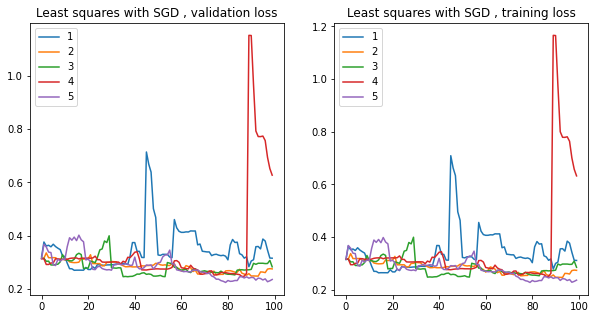

In [22]:
best_w, avg_loss = least_squares_SGD(y=y,
                                 tX=tX_std,
                                 initial_w=np.zeros(tX_std.shape[1]),
                                 max_iters=100,
                                 gamma=0.01)

### Least Squares:
Least squares regression using normal equations. Solve $A^TAx = A^Ty$, Ax = b → x = np.linalg.solve(A, b)

In [23]:
# Test of LS_normal:
best_w, avg_loss = least_squares(y=y,
                                 tX=tX_std)

Least squares with normal equations starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],
Parameters:{'max_iters': 1, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Overall data shape:(215311, 61)
Training data shape:(172248,61)
Validation data shape:(43062,61)
K = 1
Final loss:0.1512
Final accuracy:42.2623%
------------------
K = 2
Final loss:0.1494
Final accuracy:41.6980%
------------------
K = 3
Final loss:0.1484
Final accuracy:41.5169%
------------------
K = 4
Final loss:0.1480
Final accuracy:41.4472%
------------------
K = 5
Final loss:0.1478
Final accuracy:41.5424%
------------------
Average loss: 0.15
Average accuracy: 41.69%
Best loss:0.14782931114197972
Best accuracy:41.54242719799359


### Ridge Regression: 
Ridge regression using normal equations. $w^* = (X^T X+\lambda I)^{-1}X^Ty$

In [24]:
# Test of RR_normal:
best_w, avg_loss = ridge_regression(y = y, tX = tX_std, lambda_ = 0.02)

Ridge regression with normal equations starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],
Parameters:{'max_iters': 1, 'K': 5, 'lambda_': 0.02, 'poly': 2}
------------------
START TRAINING:
Overall data shape:(215311, 61)
Training data shape:(172248,61)
Validation data shape:(43062,61)
K = 1
Final loss:0.1512
Final accuracy:42.2554%
------------------
K = 2
Final loss:0.1494
Final accuracy:41.7027%
------------------
K = 3
Final loss:0.1484
Final accuracy:41.5122%
------------------
K = 4
Final loss:0.1480
Final accuracy:41.4472%
------------------
K = 5
Final loss:0.1478
Final accuracy:41.5401%
------------------
Average loss: 0.15
Average accuracy: 41.69%
Best loss:0.14782990463148862
Best accuracy:41.54010496493428


### Logistic (regularized) regression: 
Logistic regression using gradient descent or SGD. 
https://github.com/SSaishruthi/LogisticRegression_Vectorized_Implementation/blob/master/Logistic_Regression.ipynb

https://machinelearningmedium.com/2017/09/15/regularized-logistic-regression/

- cost : $J(w) = -1/m (-y^T log (h)-(1-y)^T log (1-h)) + \lambda/(2m)||w||^2 ; h = sigmoid(Xw)$

Regularized logistic regression using gradient descent or SGD. $ w^* = min_w \sum_{i=1}^n log(1+exp(-y_i w^T x_i)) +\lambda ‖w‖^2$

In [ ]:
# Test of logistic regularized regression:
best_w, avg_loss = logistic_regression(y, tX_std, np.zeros(tX_std.shape[1]*2),
                                    max_iters = 100, gamma = 0.01)

Wrong shape for initial_w, should be of shape 61. Polynomial expans of deg 2 + a bias term
We will use initial_w = 0 everywhere instead:
Logistic regression with GD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],
Parameters:{'lambda_': 0.0, 'lr': 0.01, 'max_iters': 100, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Overall data shape:(215311, 61)
Training data shape:(172248,61)
Validation data shape:(43062,61)
K = 1


In [ ]:
# Test of logistic regularized regression:
best_w, avg_loss = reg_logistic_regression(y, tX_std, lambda_ = 0.02, initial_w = np.zeros(tX_std.shape[1]),
                                    max_iters = 100, gamma = 0.01)

## Hyperparameters Tuning

### Randomized Grid search
[Cross-Validation and Hyperparameter Tuning: How to Optimise your Machine Learning Model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d)

In [ ]:
def randomized_grid_search(model,
                           tX,
                           y,
                           initial_w,
                           parameters_lists,
                           nb_rnd_test,
                           verbose=False):
    '''
    randomized_grid_search: Search the best parameters with the model among
    a list of value for each parameter.
    @input:
    - string model: 'LS_GD', 'LS_SGD', 'LS_normal', 'RR_normal' or 'LR'
    - np.array(N,m) tX: features
    - np.array(N,) y: labels
    - np.array(m,) initial_w: starting weights for GD and SGD
    - dictionary parameters_lists: A dictionary of lists of values for the parameters
        required for training (lr, lambda, etc)
    - int nb_rnd_test: number of random test to do before giving the best results it found.
    @output
    - double avg_loss: average loss over validation sets during cross-val
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - dictionary new_params: hyper-parameters with smallest generalization error
    - int nb_rnd_test: same as the input
    '''
    results = []
    for i in tqdm(range(nb_rnd_test)):
        new_params = {}

        # Select a random combinations of parameters
        for k, v in parameters_lists[model].items():
            new_params[k] = np.random.choice(v)

        param_to_test_with = {model: new_params.copy()}

        # Train the model and store the results
        best_w, avg_loss = train_model(tX, y, model, initial_w,
                                       param_to_test_with, verbose)
        results.append((avg_loss, best_w, param_to_test_with))

    # Return the parameters with the smaller loss
    return sorted(results, key=lambda e: e[0])[0], nb_rnd_test

#### Tuning

In [ ]:
# Generate parameters (adapt these as you want to) depending on the one we need for the given model
rnd_grid_search_params = {
    'LR': {
        'lambda_': [x for x in np.linspace(0.01, 0.21, 100)],
        'lr': [x for x in np.linspace(0.01, 0.21, 100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'poly': [i for i in range(1, 5)]
    },
    'LS_GD': {
        'lr': [x for x in np.linspace(0.01, 0.21, 100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'poly': [i for i in range(1, 5)]
    },
    'LS_SGD': {
        'lr': [x for x in np.linspace(0.01, 0.21, 100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'poly': [i for i in range(1, 5)],
        'batch_size': [1]
    },
    'LS_normal': {
        'max_iters': [1],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'poly': [i for i in range(1, 5)]
    },
    'RR_normal': {
        'max_iters': [1],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'lambda_': [x for x in np.linspace(0.01, 0.21, 100)],
        'poly': [i for i in range(1, 5)]
    }
}

In [ ]:
from datetime import datetime

def search_and_save_params(model,
                           tX,
                           y,
                           initial_w,
                           parameters_lists,
                           nb_rnd_test,
                           verbose=False):
    
    result = randomized_grid_search(model,
                                    tX,
                                    y,
                                    initial_w,
                                    parameters_lists,
                                    nb_rnd_test,
                                    verbose=False)
    
    now = datetime.now().strftime('%m(month)-%d_%Hh%Mm%Ss')
    model = list(result[0][2].keys())[0]

    OUTPUT_PATH = '../data/results/param_tuning_' + model + '_' + str(
        now) + '.txt'

    data = str('avg_loss:{}\nparameters:{}\nnb_rnd_try:{}\nw:{}'.format(
        result[0][0], result[0][2], result[1], result[0][1]))

    with open(OUTPUT_PATH, 'w') as output:
        output.write(str(data))

##################################################################
# /!\ If this fail, create a directory named 'results' in 'data' #
##################################################################

In [ ]:
search_and_save_params(model='LS_normal',
                       tX=tX,
                       y=y,
                       initial_w=None,
                       parameters_lists=rnd_grid_search_params,
                       nb_rnd_test=50,
                       verbose=False)

##### 50 parameter combinations tries: 

In [ ]:
experiments = 50
with open('parameters.json') as json_file:
    parameters = json.load(json_file)
    
model = 'LR'
results = []
for i in tqdm(range(experiments)):
    
    # sample from a Uniform distribution on a log-scale
    # Sample learning rate candidates in the range (0.3 to 0.03)
    lr = 3*10**np.random.uniform(-1,-2) 
    # Sample regularization candidates in the range (0.1 to 0.001)
    lambda_ = 10**np.random.uniform(-1,-3) 
    parameters[model]['lr'] = lr
    parameters[model]['lambda_'] = lambda_

    best_w, avg_loss = train_model(tX=tX,
                               model=model,
                               y=y,
                               initial_w=None,
                               param=parameters, verbose = False)
    results.append((avg_loss, best_w, parameters[model]))
sorted(results, key=lambda e: e[0])[0]   

## Training with special parameters: 

For other parameters than in the default, change json or create a new dict.

Logistic regression with GD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],
Parameters:{'lambda_': 0.0, 'lr': 0.8, 'max_iters': 500, 'K': 5, 'poly': 3}
------------------
START TRAINING:
Overall data shape:(215311, 91)
Training data shape:(172248,91)
Validation data shape:(43062,91)
K = 1
Final loss:0.4272
Final accuracy:80.4654%
------------------
K = 2
Final loss:0.4238
Final accuracy:80.5652%
------------------
K = 3
Final loss:0.4198
Final accuracy:80.7092%
------------------
K = 4
Final loss:0.4188
Final accuracy:81.1272%
------------------
K = 5
Final loss:0.4193
Final accuracy:81.0181%
------------------
Average loss: 0.42
Average accuracy: 80.78%
Best loss:0.4187810214554971
Best accuracy:81.12721192698899
------------------

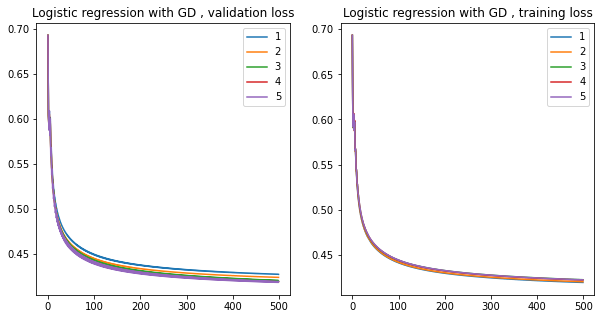

In [16]:
## Training with k-fold:
model = 'LR'

with open('data/parameters_best_model.json') as json_file:
    parameters = json.load(json_file)

poly = parameters[model]['poly']
best_w, avg_loss = train_model(tX=tX_std,
                               y=y,
                               model=model,
                               initial_w=np.zeros(tX.shape[1] * poly + 1),
                               param=parameters)

## Generate predictions and save ouput in csv format for submission:

In [17]:
# Choose method: 
from datetime import date
today = date.today().strftime('%m-%d')

# parameters:
params = ''
for param in parameters[model]:
    params+= param+'='+str(parameters[model][param])+','
    

test_prediction = predict_labels(best_w, tX_test_std)
OUTPUT_PATH = 'data/results/predictions/y_pred_' + model + '_'+str(today)+'_'+params+'.csv'
create_csv_submission(ids_test, test_prediction, OUTPUT_PATH)